In [ ]:
import Pkg
Pkg.add("Revise")
Pkg.add("IonSim")
Pkg.add("QuantumOptics")
Pkg.add("StochasticDiffEq")
Pkg.add("DSP")
using PyPlot
using Revise
using IonSim
using QuantumOptics: timeevolution, stochastic, Basis

In [3]:
C = Ca40([("S1/2", -1/2, "g"),("D5/2", -1/2, "e")])
# Create aliases for the qubit states for easier access
#set_sublevel_alias!(C, Dict("g" => ("S1/2", -1/2), "e" => ("D5/2", -1/2)))

# Define the trap configuration. We'll model a single ion in a linear chain
# with a 1 MHz axial motional frequency.
chain = LinearChain(
    ions=[C],
    comfrequencies=(x=3e6, y=3e6, z=1e6),   
    selectedmodes=(;z=[1]) # We only consider the axial mode of motion
)

# Define the laser that will drive the transition
L = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T = Chamber(
    iontrap=chain,
    B=0.37e-3,              # Magnetic field in Tesla
    #δB = 0.1,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L]
)

polarization!(L, (x̂ - ẑ)/√2)
wavevector!(L, (x̂ + ẑ)/√2);
wavelength_from_transition!(L, C, ("g", "e"), T)
intensity_from_pitime!(L, 4e-6, C, ("g", "e"), T);

ion = ions(T)[1]

ψ0_ion_1 = ion["g"]
ψ0_ion_2 = ion[("S1/2", -1/2)]
ψ0_ion_3 = ionstate(ion, "g")

print(ψ0_ion_1)
mode = modes(T)[1]

ψ0_mode_1 = mode[0]
ψ0_mode_2 = fockstate(mode, 0)
ψ0_mode_3 = groundstate(mode)

print(ψ0_mode_1)
ψ₀ = ion["g"] ⊗ mode[0];

Ket(dim=2)
  basis: ⁴⁰Ca
 1.0 + 0.0im
 0.0 + 0.0imKet(dim=11)
  basis: VibrationalMode(ν=1.0e6, axis=ẑ, N=10)
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [4]:
function pulse(T:: Chamber , tspan, pitime)
    # Define the laser that will drive the transition
    L = T.lasers[1]

    # Combine all components into a single Trap object, which represents the full experiment
    # This is the main object that holds the entire state of our physical system.
    
    pi2_time = pitime*1e6/2

    res_intensity = intensity_from_pitime(L, pitime, T.iontrap.ions[1], ("g", "e"), T)

    function intensity_funtion(t)
    if(t<=pi2_time)
        return res_intensity
    elseif(t>=tspan[end] - pi2_time)
        return res_intensity
    else
        return 0.0
    end

    end
    intensity!(L, intensity_funtion)

    function phase_funtion(t)
        if(t<=pi2_time)
            return 2*pi
        elseif(t>=tspan[end] - pi2_time)
            return pi
        else
            return 0.0
        end
    end

    phase!(L, phase_funtion)
    h = hamiltonian(T, timescale=1e-6, rwa_cutoff=Inf);
    return h
end


function experiment(T::Chamber, wait_time)
    pitime = 4e-6
    tspan = 0: 0.1: wait_time+4

    h = pulse(T, tspan, pitime)
    return h
end

# phase!(L, phase_funtion)
# h = hamiltonian(T, timescale=1e-6, rwa_cutoff=Inf);

experiment (generic function with 1 method)

In [5]:
Pkg.add("ProgressMeter")
using Distributions # You'll need to add this package!
using ProgressMeter # For a nice progress bar

   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`


In [ ]:


# --- 2. Define Noise Parameters from the Paper ---
const N_shots = 200  # Number of experiments to average over. More is better.
B_rms_shielded = 5e-9  # (T) The final shielded noise from the paper

# Create the Gaussian distribution for the magnetic field noise
# This replaces your B_span!
noise_distribution = Normal(0, B_rms_shielded)


# --- 3. Function to run ONE shot of a Ramsey experiment ---
# This function takes a specific, constant δB for a single shot
function run_ramsey_shot(t_wait, δB_shot)
    # The Chamber is now inside the function, as δB changes each time
    L = Laser()
    T = Chamber(
        iontrap=chain,
        B=0.357e-3,
        δB=δB_shot, # Use the random δB for this shot
        Bhat=ẑ,
        lasers=[L]
    )
    polarization!(L, (x̂ - ẑ)/√2)
    wavevector!(L, (x̂ + ẑ)/√2);
    wavelength_from_transition!(L, C, ("g", "e"), T)

    # Ramsey sequence: π/2 pulse, wait, π/2 pulse
    tspan = 0:0.1:t_wait*1e6
    h = pulse(T, tspan, 4e-6)
    tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ₀, h)
    # Note: Rabi frequency and pulse times are illustrative
    # Ω = 2π * 50e3
    # τ_π_half = π / (2Ω)

    # # First π/2 pulse
    # _, sol_1 = timeevolution.schroedinger_dynamic(0:0.01e-6:τ_π_half, ψ₀, h)
    # ψ_after_pulse1 = last(sol_1)

    # # Wait time (free evolution)
    # # During the wait, only the base Hamiltonian h affects the ion
    # _, sol_wait = timeevolution.schroedinger_dynamic(0:0.01e-6:t_wait, ψ_after_pulse1, h)
    # ψ_after_wait = last(sol_wait)

    # # Second π/2 pulse
    # _, sol_2 = timeevolution.schroedinger_dynamic(0:0.01e-6:τ_π_half, ψ_after_wait, h)
    # ψ_final = last(sol_2)

    # Return the final probability of being in the 'g' state
    return expect(ionprojector(T, "g"), sol[end])
end


# --- 4. Main Simulation Loop (Ensemble Average) ---
function simulate_decoherence()
    wait_times = 1e-5:5e-6:3e-3 # Simulate for 300 ms, as in the paper's Ramsey fig
    avg_g_population = []

    @showprogress "Simulating Ramsey Fringes..." for t in wait_times
        final_pops_for_t = zeros(N_shots)
        for i in 1:N_shots
            # For each shot, draw a NEW random magnetic field offset
            δB_shot = rand(noise_distribution)
            final_pops_for_t[i] = run_ramsey_shot(t, δB_shot)
        end
        # Average the results from all shots for this wait time
        push!(avg_g_population, real(sum(final_pops_for_t) / N_shots))
        # println("Wait time $(t*1e3) ms: Avg. g-pop = $(avg_g_population)")
    end
    return wait_times, avg_g_population
end



simulate_decoherence (generic function with 1 method)

Running simulation with SHIELDED noise (B_rms = 5.0e-9 T)


Simulating Ramsey Fringes... 100%|███████████████████████| Time: 0:18:10


1.0e-5:5.0e-6:0.003
Any[0.9999251164550863, 0.9999228697893904, 0.9999153198108475, 0.9999138302201906, 0.9999107950846806, 0.9998831795812941, 0.9998794159886946, 0.9998783683330922, 0.9998722553600682, 0.9998689336701213, 0.9998654200754029, 0.9998578942925976, 0.9997426251012245, 0.9997326095761775, 0.999735173997123, 0.9997340376070238, 0.9997126054907599, 0.9997123072234398, 0.9997038399514279, 0.9996823370017057, 0.999699463981325, 0.9996728906662673, 0.9996550554927489, 0.9996693942603859, 0.9996288152484049, 0.9991939877676512, 0.9991859226478408, 0.9992045381835714, 0.9991686071549993, 0.9991571278872817, 0.9991530253523997, 0.9991601871651234, 0.9991388111717926, 0.9990613813531048, 0.9991025788777012, 0.9991087557833871, 0.9990536776844066, 0.9991014038324987, 0.9990661971512214, 0.9989816714452533, 0.999015347816521, 0.9990262251163032, 0.9989363516045283, 0.9989706332868057, 0.9989409474093636, 0.9989218971404044, 0.9989152389049303, 0.9989390180465183, 0.99890544270675, 0

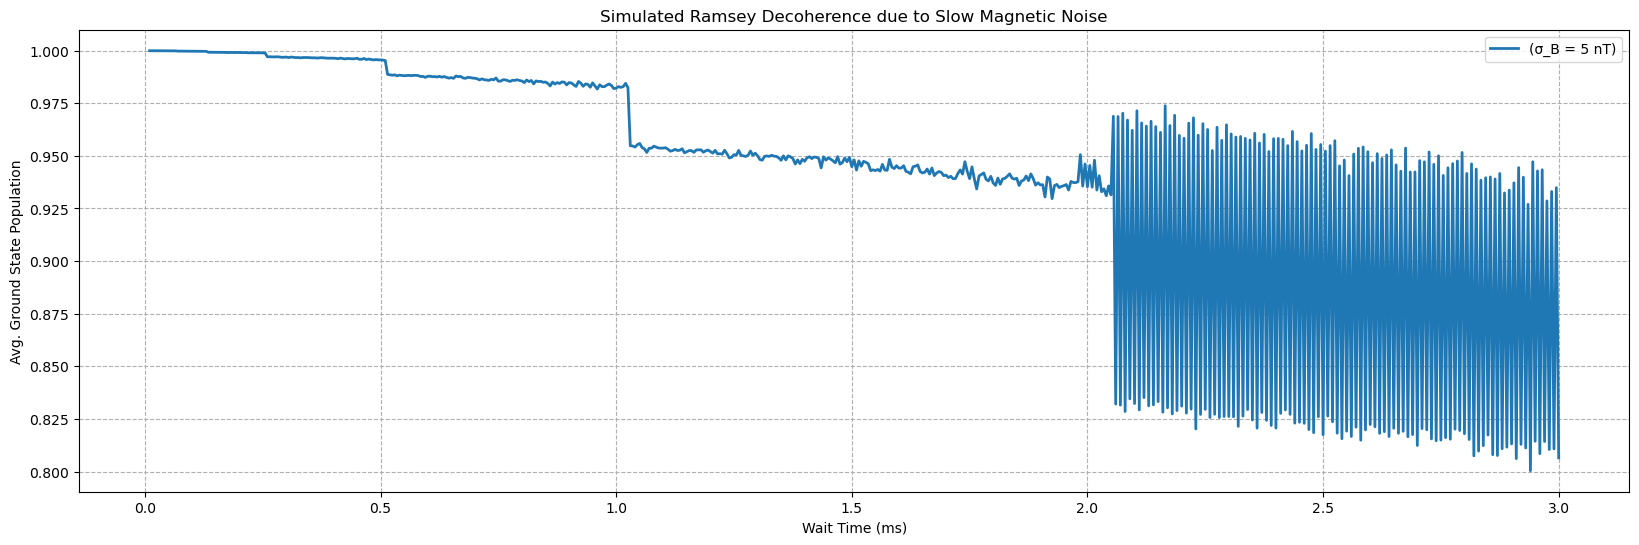

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


In [7]:
# --- 5. Run and Plot ---
println("Running simulation with SHIELDED noise (B_rms = $B_rms_shielded T)")
times, pops = simulate_decoherence()
println(times)
println(pops)

# You can re-run with the unshielded value to compare!
# noise_distribution = Normal(0, B_rms_unshielded)
# println("Running simulation with UNSHIELDED noise (B_rms = $B_rms_unshielded T)")
# times_unshielded, pops_unshielded = simulate_decoherence()

figure(figsize=(20, 6))
plot(times * 1e3, pops, label="(σ_B = 5 nT)", linewidth=2)
# plot(times_unshielded * 1e3, pops_unshielded, label="Unshielded Simulation (σ_B = 27 pT)", linewidth=2)

xlabel("Wait Time (ms)")
ylabel("Avg. Ground State Population")
#ylim(0, 1e-11)
title("Simulated Ramsey Decoherence due to Slow Magnetic Noise")
grid(true, linestyle="--")
legend()
show()
display(gcf())

In [6]:
#  --- 1. System Setup (similar to your code) ---
# C = Ca40()
# chain = LinearChain(
#     ions=[C],
#     com_frequencies=(x=2e6, y=2e6, z=1e6),
#     vibrational_modes=(x=[1], y=[1], z=[1])
# )
# ψ₀ = product_state(C, "g")

# --- 2. Define Noise Parameters from the Paper ---
const N_shots = 200  # Number of experiments to average over. More is better.
B_rms_1 = 5e-9  # (T) The final shielded noise from the paper


# Create the Gaussian distribution for the magnetic field noise
# This replaces your B_span!
noise_distribution_1 = Normal(0, B_rms_1)


# --- 3. Function to run ONE shot of a Ramsey experiment ---
# This function takes a specific, constant δB for a single shot
function run_ramsey_shot(t_wait, δB_shot)
    # The Chamber is now inside the function, as δB changes each time
    L = Laser()
    T = Chamber(
        iontrap=chain,
        B=0.357e-3,
        δB=δB_shot, # Use the random δB for this shot
        Bhat=ẑ,
        lasers=[L]
    )
    polarization!(L, (x̂ - ẑ)/√2)
    wavevector!(L, (x̂ + ẑ)/√2);
    wavelength_from_transition!(L, C, ("g", "e"), T)

    # Ramsey sequence: π/2 pulse, wait, π/2 pulse
    tspan = 0:10:t_wait*1e6
    h = pulse(T, tspan, 4e-6)
    tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ₀, h)
    # Note: Rabi frequency and pulse times are illustrative
    # Ω = 2π * 50e3
    # τ_π_half = π / (2Ω)

    # # First π/2 pulse
    # _, sol_1 = timeevolution.schroedinger_dynamic(0:0.01e-6:τ_π_half, ψ₀, h)
    # ψ_after_pulse1 = last(sol_1)

    # # Wait time (free evolution)
    # # During the wait, only the base Hamiltonian h affects the ion
    # _, sol_wait = timeevolution.schroedinger_dynamic(0:0.01e-6:t_wait, ψ_after_pulse1, h)
    # ψ_after_wait = last(sol_wait)

    # # Second π/2 pulse
    # _, sol_2 = timeevolution.schroedinger_dynamic(0:0.01e-6:τ_π_half, ψ_after_wait, h)
    # ψ_final = last(sol_2)

    # Return the final probability of being in the 'g' state
    return expect(ionprojector(T, "g"), sol[end])
end


# --- 4. Main Simulation Loop (Ensemble Average) ---
function simulate_decoherence(noise_distribution)
    wait_times = 10e-6:1e-2:6e-1 # Simulate for 300 ms, as in the paper's Ramsey fig
    avg_g_population = []

    @showprogress "Simulating Ramsey Fringes..." for t in wait_times
        final_pops_for_t = zeros(N_shots)
        for i in 1:N_shots
            # For each shot, draw a NEW random magnetic field offset
            δB_shot = rand(noise_distribution)
            final_pops_for_t[i] = run_ramsey_shot(t, δB_shot)
        end
        # Average the results from all shots for this wait time
        push!(avg_g_population, real(sum(final_pops_for_t) / N_shots))
        # println("Wait time $(t*1e3) ms: Avg. g-pop = $(avg_g_population)")
    end
    return wait_times, avg_g_population
end



simulate_decoherence (generic function with 1 method)

In [ ]:
# --- 5. Run and Plot ---
println("Running simulation with SHIELDED noise (B_rms = $B_rms_1 T)")
times, pops = simulate_decoherence(noise_distribution_1)
println(times)
println(pops)

# You can re-run with the unshielded value to compare!
# noise_distribution = Normal(0, B_rms_unshielded)
# println("Running simulation with UNSHIELDED noise (B_rms = $B_rms_unshielded T)")
# times_unshielded, pops_unshielded = simulate_decoherence()

figure(figsize=(20, 6))
plot(times * 1e3, pops, label="(σ_B = 5 nT)", linewidth=2)
# plot(times_unshielded * 1e3, pops_unshielded, label="Unshielded Simulation (σ_B = 27 pT)", linewidth=2)

xlabel("Wait Time (ms)")
ylabel("Avg. Ground State Population")
#ylim(0, 1e-11)
title("Simulated Ramsey Decoherence due to Slow Magnetic Noise")
grid(true, linestyle="--")
legend()
show()
display(gcf())

Running simulation with SHIELDED noise (B_rms = 5.0e-9 T)


Simulating Ramsey Fringes...  15%|████                   |  ETA: 2:19:16

Running simulation with SHIELDED noise (B_rms = 5.0e-9 T)


Simulating Ramsey Fringes... 100%|███████████████████████| Time: 0:01:35


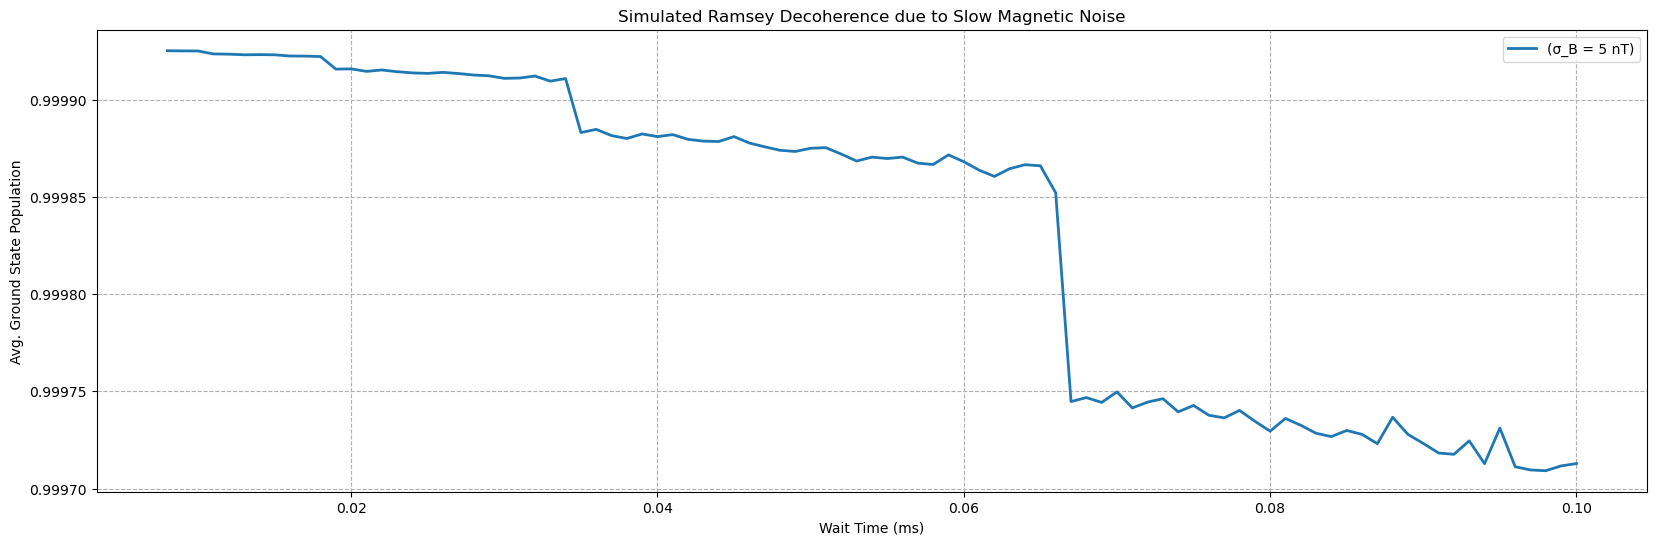

8.0e-6:1.0e-6:0.0001
Any[0.9999251853388179, 0.9999250958799872, 0.9999250514966057, 0.999923535784044, 0.9999234232141002, 0.9999230988550655, 0.9999231818611064, 0.9999230807800953, 0.9999224538998015, 0.9999224226885935, 0.9999221874004331, 0.9999157363290501, 0.999915848552141, 0.9999145627514558, 0.9999152853486786, 0.9999143967289538, 0.999913780079169, 0.9999135293236763, 0.9999140670067601, 0.99991345947121, 0.9999126849792477, 0.9999122878093071, 0.9999109755015289, 0.9999111460980634, 0.9999121638298615, 0.9999095351512303, 0.9999108601230815, 0.9998831043023738, 0.9998847268929283, 0.99988153540544, 0.9998800452479624, 0.9998823884745451, 0.9998810127114273, 0.999882023604915, 0.9998795997282032, 0.999878688801339, 0.9998784905973267, 0.9998810068394399, 0.9998777101672452, 0.9998757397157028, 0.9998739791823427, 0.9998733774753216, 0.9998750042942903, 0.9998753221864399, 0.9998720174841224, 0.9998684485958813, 0.9998704636614607, 0.9998697428757458, 0.9998704713746156, 0.99

In [10]:
# --- 5. Run and Plot ---
println("Running simulation with SHIELDED noise (B_rms = $B_rms_shielded T)")
times, pops = simulate_decoherence(noise_distribution_1)
println(times)
println(pops)

# You can re-run with the unshielded value to compare!
# noise_distribution = Normal(0, B_rms_unshielded)
# println("Running simulation with UNSHIELDED noise (B_rms = $B_rms_unshielded T)")
# times_unshielded, pops_unshielded = simulate_decoherence()

figure(figsize=(20, 6))
plot(times * 1e3, pops, label="(σ_B = 5 nT)", linewidth=2)
# plot(times_unshielded * 1e3, pops_unshielded, label="Unshielded Simulation (σ_B = 27 pT)", linewidth=2)

xlabel("Wait Time (ms)")
ylabel("Avg. Ground State Population")
#ylim(0, 1e-11)
title("Simulated Ramsey Decoherence due to Slow Magnetic Noise")
grid(true, linestyle="--")
legend()
show()
display(gcf())

In [11]:
#  --- 1. System Setup (similar to your code) ---
# C = Ca40()
# chain = LinearChain(
#     ions=[C],
#     com_frequencies=(x=2e6, y=2e6, z=1e6),
#     vibrational_modes=(x=[1], y=[1], z=[1])
# )
# ψ₀ = product_state(C, "g")

# --- 2. Define Noise Parameters from the Paper ---
const N_shots = 200  # Number of experiments to average over. More is better.
B_rms_1 = 1e-6  # (T) The final shielded noise from the paper
B_rms_2 = 2e-6 # (T) Example for 20 dB worse noise
B_rms_3 = 3e-6 # (T) Example for 20 dB worse noise

# Create the Gaussian distribution for the magnetic field noise
# This replaces your B_span!
noise_distribution_1 = Normal(0, B_rms_1)
noise_distribution_2 = Normal(0, B_rms_2)
noise_distribution_3 = Normal(0, B_rms_3)


# --- 3. Function to run ONE shot of a Ramsey experiment ---
# This function takes a specific, constant δB for a single shot
function run_ramsey_shot(t_wait, δB_shot)
    # The Chamber is now inside the function, as δB changes each time
    L = Laser()
    T = Chamber(
        iontrap=chain,
        B=0.37e-3,
        δB=δB_shot, # Use the random δB for this shot
        Bhat=ẑ,
        lasers=[L]
    )
    polarization!(L, (x̂ - ẑ)/√2)
    wavevector!(L, (x̂ + ẑ)/√2);
    wavelength_from_transition!(L, C, ("g", "e"), T)

    # Ramsey sequence: π/2 pulse, wait, π/2 pulse
    tspan = 0:0.1:t_wait*1e6
    h = pulse(T, tspan, 4e-6)
    tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ₀, h)
    # Note: Rabi frequency and pulse times are illustrative
    # Ω = 2π * 50e3
    # τ_π_half = π / (2Ω)

    # # First π/2 pulse
    # _, sol_1 = timeevolution.schroedinger_dynamic(0:0.01e-6:τ_π_half, ψ₀, h)
    # ψ_after_pulse1 = last(sol_1)

    # # Wait time (free evolution)
    # # During the wait, only the base Hamiltonian h affects the ion
    # _, sol_wait = timeevolution.schroedinger_dynamic(0:0.01e-6:t_wait, ψ_after_pulse1, h)
    # ψ_after_wait = last(sol_wait)

    # # Second π/2 pulse
    # _, sol_2 = timeevolution.schroedinger_dynamic(0:0.01e-6:τ_π_half, ψ_after_wait, h)
    # ψ_final = last(sol_2)

    # Return the final probability of being in the 'g' state
    return expect(ionprojector(T, "g"), sol[end])
end


# --- 4. Main Simulation Loop (Ensemble Average) ---
function simulate_decoherence(noise_distribution)
    wait_times = 8e-6:1e-6:1e-4 # Simulate for 300 ms, as in the paper's Ramsey fig
    avg_g_population = []

    @showprogress "Simulating Ramsey Fringes..." for t in wait_times
        final_pops_for_t = zeros(N_shots)
        for i in 1:N_shots
            # For each shot, draw a NEW random magnetic field offset
            δB_shot = rand(noise_distribution)
            final_pops_for_t[i] = run_ramsey_shot(t, δB_shot)
        end
        # Average the results from all shots for this wait time
        push!(avg_g_population, real(sum(final_pops_for_t) / N_shots))
        # println("Wait time $(t*1e3) ms: Avg. g-pop = $(avg_g_population)")
    end
    return wait_times, avg_g_population
end



simulate_decoherence (generic function with 2 methods)

Running simulation with various noise (B_rms = 1e-6, 2e-6, 3e-6)


Simulating Ramsey Fringes... 100%|███████████████████████| Time: 0:01:37
Simulating Ramsey Fringes... 100%|███████████████████████| Time: 0:01:39
Simulating Ramsey Fringes... 100%|███████████████████████| Time: 0:01:43


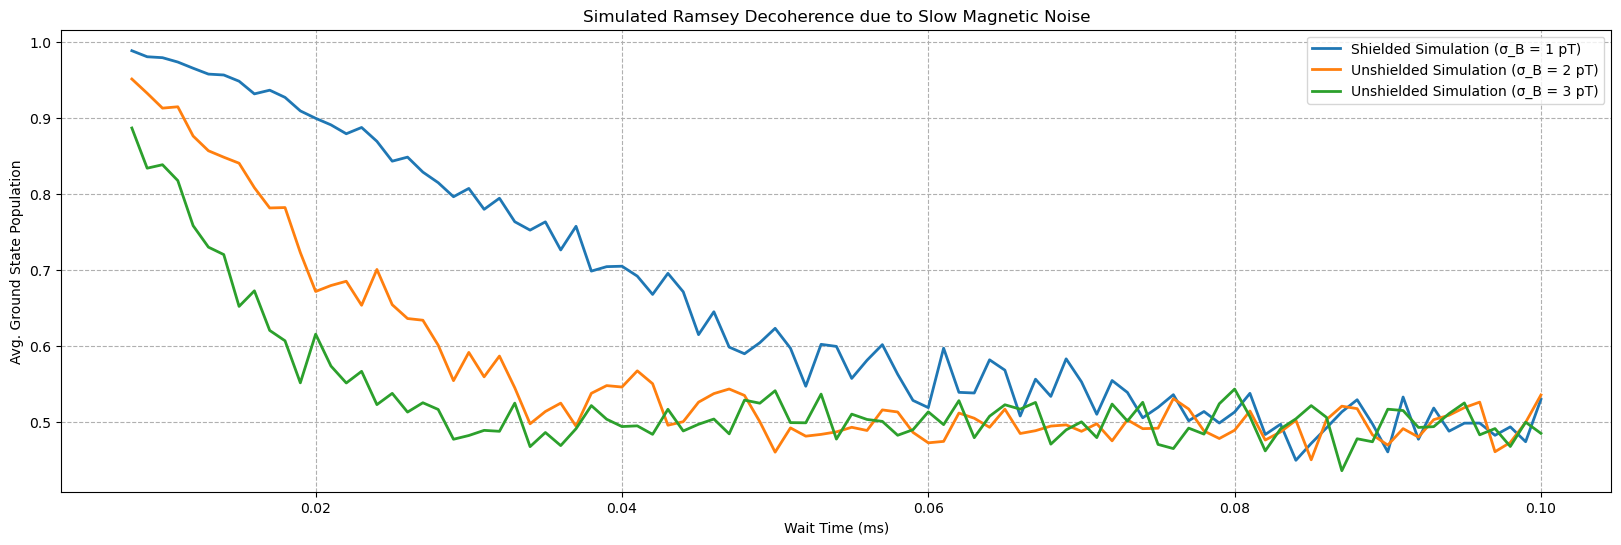

In [12]:
# --- 5. Run and Plot ---
println("Running simulation with various noise (B_rms = 1e-6, 2e-6, 3e-6)")
times_1, pops_1 = simulate_decoherence(noise_distribution_1)
times_2, pops_2 = simulate_decoherence(noise_distribution_2)
times_3, pops_3 = simulate_decoherence(noise_distribution_3)

# You can re-run with the unshielded value to compare!
# noise_distribution = Normal(0, B_rms_unshielded)
# println("Running simulation with UNSHIELDED noise (B_rms = $B_rms_unshielded T)")
# times_unshielded, pops_unshielded = simulate_decoherence()

figure(figsize=(20, 6))
plot(times_1 * 1e3, pops_1, label="Shielded Simulation (σ_B = 1 pT)", linewidth=2)
plot(times_2 * 1e3, pops_2, label="Unshielded Simulation (σ_B = 2 pT)", linewidth=2)
plot(times_3 * 1e3, pops_3, label="Unshielded Simulation (σ_B = 3 pT)", linewidth=2)

xlabel("Wait Time (ms)")
ylabel("Avg. Ground State Population")
#ylim(0, 1e-11)
title("Simulated Ramsey Decoherence due to Slow Magnetic Noise")
grid(true, linestyle="--")
legend()
show()
display(gcf())

Running simulation with various noise (B_rms = 1e-6, 2e-6, 3e-6)


Simulating Ramsey Fringes... 100%|███████████████████████| Time: 0:01:34
Simulating Ramsey Fringes... 100%|███████████████████████| Time: 0:01:41
Simulating Ramsey Fringes... 100%|███████████████████████| Time: 0:01:49


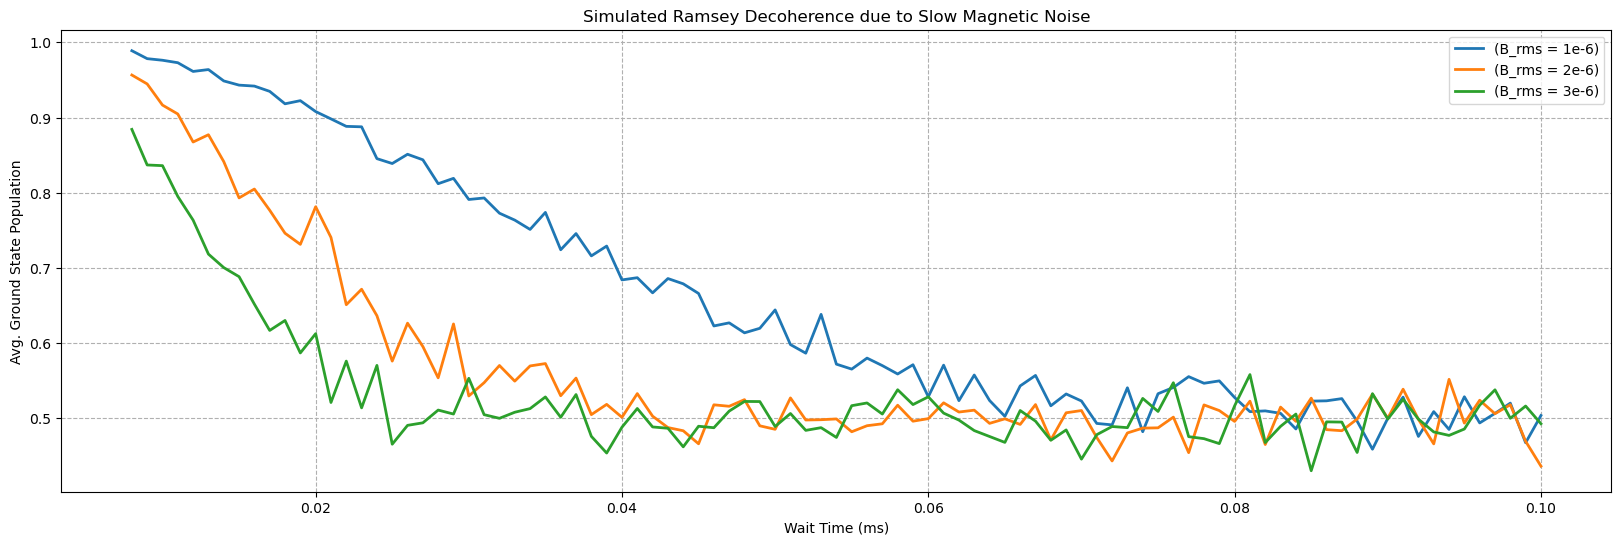

In [13]:
# --- 5. Run and Plot ---
println("Running simulation with various noise (B_rms = 1e-6, 2e-6, 3e-6)")
times_1, pops_1 = simulate_decoherence(noise_distribution_1)
times_2, pops_2 = simulate_decoherence(noise_distribution_2)
times_3, pops_3 = simulate_decoherence(noise_distribution_3)

# You can re-run with the unshielded value to compare!
# noise_distribution = Normal(0, B_rms_unshielded)
# println("Running simulation with UNSHIELDED noise (B_rms = $B_rms_unshielded T)")
# times_unshielded, pops_unshielded = simulate_decoherence()

figure(figsize=(20, 6))
plot(times_1 * 1e3, pops_1, label="(B_rms = 1e-6)", linewidth=2)
plot(times_2 * 1e3, pops_2, label="(B_rms = 2e-6)", linewidth=2)
plot(times_3 * 1e3, pops_3, label="(B_rms = 3e-6)", linewidth=2)

xlabel("Wait Time (ms)")
ylabel("Avg. Ground State Population")
#ylim(0, 1e-11)
title("Simulated Ramsey Decoherence due to Slow Magnetic Noise")
grid(true, linestyle="--")
legend()
show()
display(gcf())

In [14]:
#  --- 1. System Setup (similar to your code) ---
# C = Ca40()
# chain = LinearChain(
#     ions=[C],
#     com_frequencies=(x=2e6, y=2e6, z=1e6),
#     vibrational_modes=(x=[1], y=[1], z=[1])
# )
# ψ₀ = product_state(C, "g")

# --- 2. Define Noise Parameters from the Paper ---
const N_shots = 200  # Number of experiments to average over. More is better.
B_rms_1 = 1e-6  # (T) The final shielded noise from the paper
B_rms_2 = 0.5e-6 # (T) Example for 20 dB worse noise
B_rms_3 = 0.1e-6 # (T) Example for 20 dB worse noise

# Create the Gaussian distribution for the magnetic field noise
# This replaces your B_span!
noise_distribution_1 = Normal(0, B_rms_1)
noise_distribution_2 = Normal(0, B_rms_2)
noise_distribution_3 = Normal(0, B_rms_3)


# --- 3. Function to run ONE shot of a Ramsey experiment ---
# This function takes a specific, constant δB for a single shot
function run_ramsey_shot(t_wait, δB_shot)
    # The Chamber is now inside the function, as δB changes each time
    L = Laser()
    T = Chamber(
        iontrap=chain,
        B=0.37e-3,
        δB=δB_shot, # Use the random δB for this shot
        Bhat=ẑ,
        lasers=[L]
    )
    polarization!(L, (x̂ - ẑ)/√2)
    wavevector!(L, (x̂ + ẑ)/√2);
    wavelength_from_transition!(L, C, ("g", "e"), T)

    # Ramsey sequence: π/2 pulse, wait, π/2 pulse
    tspan = 0:0.1:t_wait*1e6
    h = pulse(T, tspan, 4e-6)
    tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ₀, h)
    # Note: Rabi frequency and pulse times are illustrative
    # Ω = 2π * 50e3
    # τ_π_half = π / (2Ω)

    # # First π/2 pulse
    # _, sol_1 = timeevolution.schroedinger_dynamic(0:0.01e-6:τ_π_half, ψ₀, h)
    # ψ_after_pulse1 = last(sol_1)

    # # Wait time (free evolution)
    # # During the wait, only the base Hamiltonian h affects the ion
    # _, sol_wait = timeevolution.schroedinger_dynamic(0:0.01e-6:t_wait, ψ_after_pulse1, h)
    # ψ_after_wait = last(sol_wait)

    # # Second π/2 pulse
    # _, sol_2 = timeevolution.schroedinger_dynamic(0:0.01e-6:τ_π_half, ψ_after_wait, h)
    # ψ_final = last(sol_2)

    # Return the final probability of being in the 'g' state
    return expect(ionprojector(T, "g"), sol[end])
end


# --- 4. Main Simulation Loop (Ensemble Average) ---
function simulate_decoherence(noise_distribution)
    wait_times = 8e-6:1e-6:2e-4 # Simulate for 300 ms, as in the paper's Ramsey fig
    avg_g_population = []

    @showprogress "Simulating Ramsey Fringes..." for t in wait_times
        final_pops_for_t = zeros(N_shots)
        for i in 1:N_shots
            # For each shot, draw a NEW random magnetic field offset
            δB_shot = rand(noise_distribution)
            final_pops_for_t[i] = run_ramsey_shot(t, δB_shot)
        end
        # Average the results from all shots for this wait time
        push!(avg_g_population, real(sum(final_pops_for_t) / N_shots))
        # println("Wait time $(t*1e3) ms: Avg. g-pop = $(avg_g_population)")
    end
    return wait_times, avg_g_population
end



simulate_decoherence (generic function with 2 methods)

Running simulation with various noise (B_rms = 1e-6, 0.5e-6, 0.1e-6)


Simulating Ramsey Fringes... 100%|███████████████████████| Time: 0:03:32
Simulating Ramsey Fringes... 100%|███████████████████████| Time: 0:03:26
Simulating Ramsey Fringes... 100%|███████████████████████| Time: 0:03:32


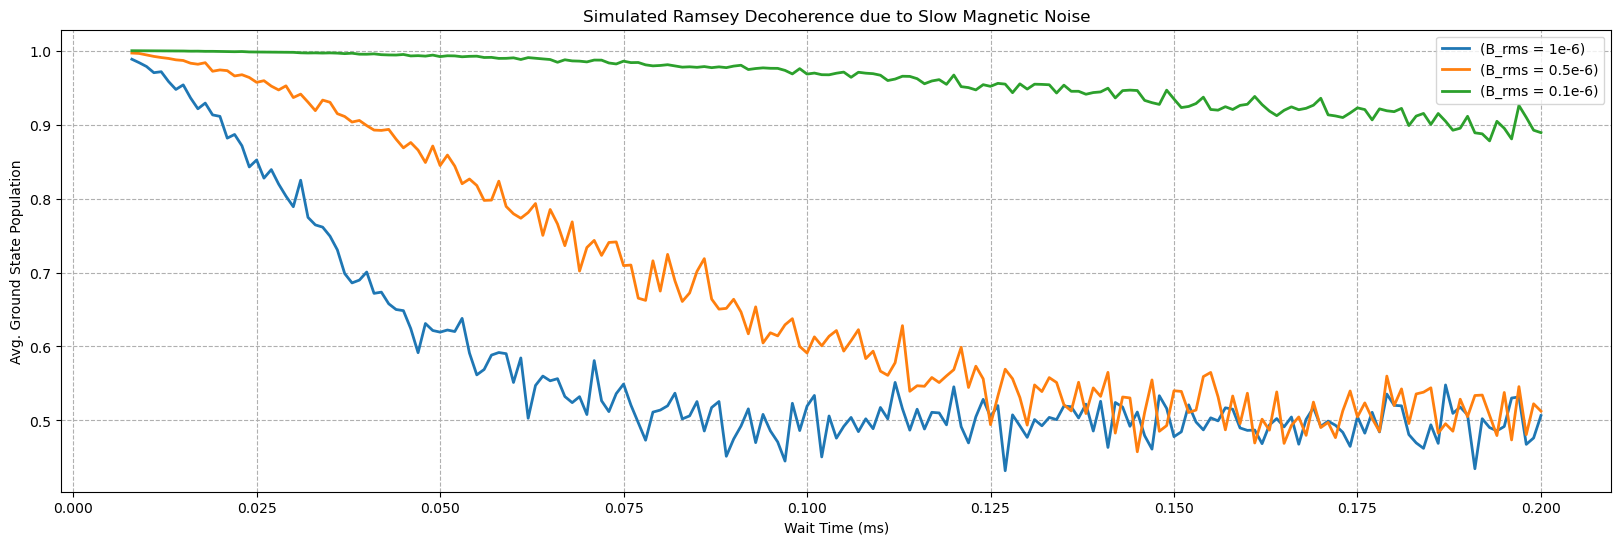

In [15]:
# --- 5. Run and Plot ---
println("Running simulation with various noise (B_rms = 1e-6, 0.5e-6, 0.1e-6)")
times_1, pops_1 = simulate_decoherence(noise_distribution_1)
times_2, pops_2 = simulate_decoherence(noise_distribution_2)
times_3, pops_3 = simulate_decoherence(noise_distribution_3)

# You can re-run with the unshielded value to compare!
# noise_distribution = Normal(0, B_rms_unshielded)
# println("Running simulation with UNSHIELDED noise (B_rms = $B_rms_unshielded T)")
# times_unshielded, pops_unshielded = simulate_decoherence()

figure(figsize=(20, 6))
plot(times_1 * 1e3, pops_1, label="(B_rms = 1e-6)", linewidth=2)
plot(times_2 * 1e3, pops_2, label="(B_rms = 0.5e-6)", linewidth=2)
plot(times_3 * 1e3, pops_3, label="(B_rms = 0.1e-6)", linewidth=2)

xlabel("Wait Time (ms)")
ylabel("Avg. Ground State Population")
#ylim(0, 1e-11)
title("Simulated Ramsey Decoherence due to Slow Magnetic Noise")
grid(true, linestyle="--")
legend()
show()
display(gcf())

In [16]:
#  --- 1. System Setup (similar to your code) ---
# C = Ca40()
# chain = LinearChain(
#     ions=[C],
#     com_frequencies=(x=2e6, y=2e6, z=1e6),
#     vibrational_modes=(x=[1], y=[1], z=[1])
# )
# ψ₀ = product_state(C, "g")

# --- 2. Define Noise Parameters from the Paper ---
const N_shots = 200  # Number of experiments to average over. More is better.
B_rms_1 = 1e-9  # (T) The final shielded noise from the paper
B_rms_2 = 2e-9 # (T) Example for 20 dB worse noise
B_rms_3 = 3e-9 # (T) Example for 20 dB worse noise

# Create the Gaussian distribution for the magnetic field noise
# This replaces your B_span!
noise_distribution_1 = Normal(0, B_rms_1)
noise_distribution_2 = Normal(0, B_rms_2)
noise_distribution_3 = Normal(0, B_rms_3)


# --- 3. Function to run ONE shot of a Ramsey experiment ---
# This function takes a specific, constant δB for a single shot
function run_ramsey_shot(t_wait, δB_shot)
    # The Chamber is now inside the function, as δB changes each time
    L = Laser()
    T = Chamber(
        iontrap=chain,
        B=0.37e-3,
        δB=δB_shot, # Use the random δB for this shot
        Bhat=ẑ,
        lasers=[L]
    )
    polarization!(L, (x̂ - ẑ)/√2)
    wavevector!(L, (x̂ + ẑ)/√2);
    wavelength_from_transition!(L, C, ("g", "e"), T)

    # Ramsey sequence: π/2 pulse, wait, π/2 pulse
    tspan = 0:0.1:t_wait*1e6
    h = pulse(T, tspan, 4e-6)
    tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ₀, h)
    # Note: Rabi frequency and pulse times are illustrative
    # Ω = 2π * 50e3
    # τ_π_half = π / (2Ω)

    # # First π/2 pulse
    # _, sol_1 = timeevolution.schroedinger_dynamic(0:0.01e-6:τ_π_half, ψ₀, h)
    # ψ_after_pulse1 = last(sol_1)

    # # Wait time (free evolution)
    # # During the wait, only the base Hamiltonian h affects the ion
    # _, sol_wait = timeevolution.schroedinger_dynamic(0:0.01e-6:t_wait, ψ_after_pulse1, h)
    # ψ_after_wait = last(sol_wait)

    # # Second π/2 pulse
    # _, sol_2 = timeevolution.schroedinger_dynamic(0:0.01e-6:τ_π_half, ψ_after_wait, h)
    # ψ_final = last(sol_2)

    # Return the final probability of being in the 'g' state
    return expect(ionprojector(T, "g"), sol[end])
end


# --- 4. Main Simulation Loop (Ensemble Average) ---
function simulate_decoherence(noise_distribution)
    wait_times = 8e-6:6e-4:6e-1 # Simulate for 600 ms, as in the paper's Ramsey fig
    avg_g_population = []

    @showprogress "Simulating Ramsey Fringes..." for t in wait_times
        final_pops_for_t = zeros(N_shots)
        for i in 1:N_shots
            # For each shot, draw a NEW random magnetic field offset
            δB_shot = rand(noise_distribution)
            final_pops_for_t[i] = run_ramsey_shot(t, δB_shot)
        end
        # Average the results from all shots for this wait time
        push!(avg_g_population, real(sum(final_pops_for_t) / N_shots))
        # println("Wait time $(t*1e3) ms: Avg. g-pop = $(avg_g_population)")
    end
    return wait_times, avg_g_population
end



simulate_decoherence (generic function with 2 methods)

In [ ]:
# --- 5. Run and Plot ---
println("Running simulation with various noise (B_rms = 1e-9, 2e-9, 3e-9)")
times_1, pops_1 = simulate_decoherence(noise_distribution_1)
times_2, pops_2 = simulate_decoherence(noise_distribution_2)
times_3, pops_3 = simulate_decoherence(noise_distribution_3)

# You can re-run with the unshielded value to compare!
# noise_distribution = Normal(0, B_rms_unshielded)
# println("Running simulation with UNSHIELDED noise (B_rms = $B_rms_unshielded T)")
# times_unshielded, pops_unshielded = simulate_decoherence()

figure(figsize=(20, 6))
plot(times_1 * 1e3, pops_1, label="(B_rms = 1e-9)", linewidth=2)
plot(times_2 * 1e3, pops_2, label="(B_rms = 2e-9)", linewidth=2)
plot(times_3 * 1e3, pops_3, label="(B_rms = 3e-9)", linewidth=2)

xlabel("Wait Time (ms)")
ylabel("Avg. Ground State Population")
#ylim(0, 1e-11)
title("Simulated Ramsey Decoherence due to Slow Magnetic Noise")
grid(true, linestyle="--")
legend()
show()
display(gcf())

Running simulation with various noise (B_rms = 1e-9, 2e-9, 3e-9)


Simulating Ramsey Fringes...   2%|█                      |  ETA: 1:32:03

In [ ]:
figure(figsize=(20, 6))
plot(times_1 * 1e3, pops_1, label="(B_rms = 1e-6)", linewidth=2)
plot(times_2 * 1e3, pops_2, label="(B_rms = 0.5e-6)", linewidth=2)
plot(times_3 * 1e3, pops_3, label="(B_rms = 0.1e-6)", linewidth=2)

xlabel("Wait Time (ms)")
ylabel("Avg. Ground State Population")
#ylim(0, 1e-11)
title("Simulated Ramsey Decoherence due to Slow Magnetic Noise")
grid(true, linestyle="--")
legend()
show()
display(gcf())